Movies DataFrame shape: (62423, 5)
First 5 rows of movies DataFrame:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   

                                                 tag  \
0  Owned imdb top 250 Pixar Pixar time travel chi...   
1  Robin Williams time travel fantasy based on ch...   
2  funny best friend duringcreditsstinger fishing...   
3  based on novel or book chick flick divorce int...   
4  aging baby confidence contraception daughter 

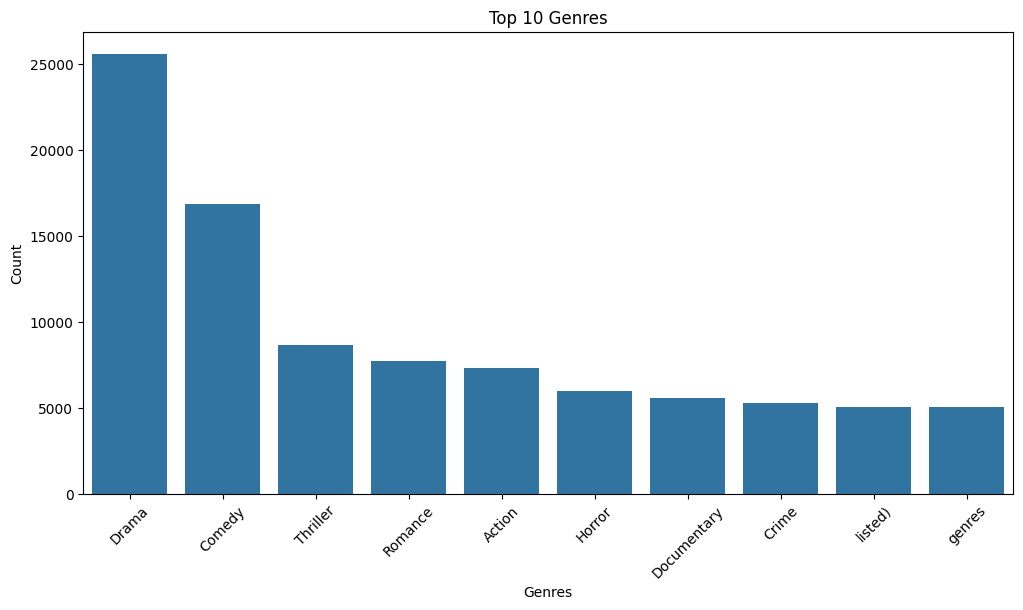

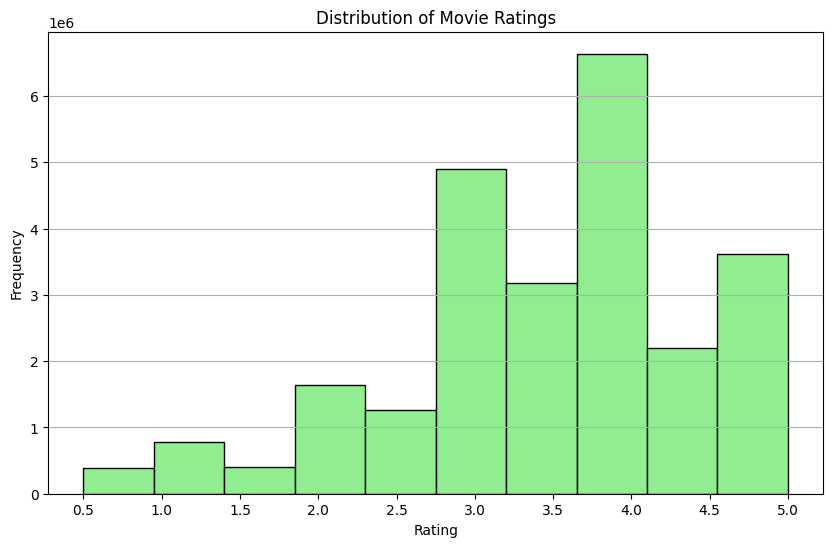

Evaluation Metrics:
Mean Absolute Error (MAE): 0.8411
Root Mean Squared Error (RMSE): 1.0604
Accuracy: 0.6768


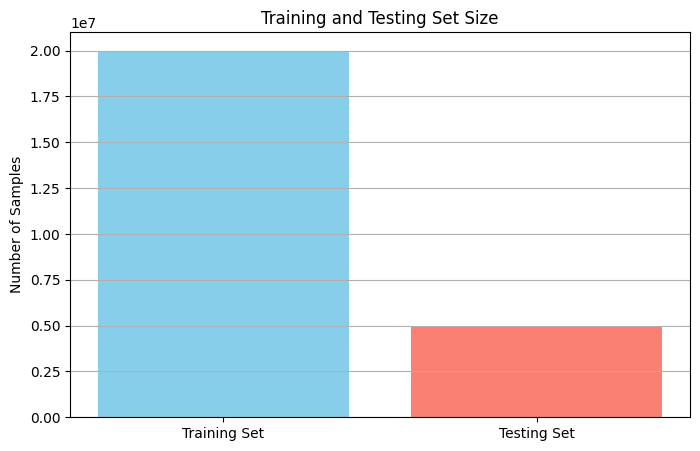

Enter a keyword (movie name, actor, director, genre): Iron Man

Recommendations for 'Iron Man':
Title: Iron Man (2008) | Genres: Action Adventure Sci-Fi | Average Rating: 3.83 | Movie ID: 59315
Title: Iron Man 2 (2010) | Genres: Action Adventure Sci-Fi Thriller IMAX | Average Rating: 3.48 | Movie ID: 77561
Title: X-Men: The Last Stand (2006) | Genres: Action Sci-Fi Thriller | Average Rating: 3.25 | Movie ID: 45499
Title: X-Men (2000) | Genres: Action Adventure Sci-Fi | Average Rating: 3.56 | Movie ID: 3793
Title: X2: X-Men United (2003) | Genres: Action Adventure Sci-Fi Thriller | Average Rating: 3.60 | Movie ID: 6333
Title: X-Men Origins: Wolverine (2009) | Genres: Action Sci-Fi Thriller | Average Rating: 3.18 | Movie ID: 68319
Title: X-Men: First Class (2011) | Genres: Action Adventure Sci-Fi Thriller War | Average Rating: 3.73 | Movie ID: 87232
Title: Transformers (2007) | Genres: Action Sci-Fi Thriller IMAX | Average Rating: 3.09 | Movie ID: 53996
Title: Ant-Man (2015) | Genres: Ac

,movieId,title,genres,tag,text,average_rating,rating
12324,59315,Iron Man (2008),Action Adventure Sci-Fi,Marvel own superhero afghanistan android(s)/cy...,Iron Man (2008) Action Adventure Sci-Fi Marvel...,3.833801,3.833801
14628,77561,Iron Man 2 (2010),Action Adventure Sci-Fi Thriller IMAX,Marvel own superhero bad science Robert Downey...,Iron Man 2 (2010) Action Adventure Sci-Fi Thri...,3.480417,3.480417
10804,45499,X-Men: The Last Stand (2006),Action Sci-Fi Thriller,aftercreditsstinger based on comic beast cyclo...,X-Men: The Last Stand (2006) Action Sci-Fi Thr...,3.253787,3.253787
3692,3793,X-Men (2000),Action Adventure Sci-Fi,action comic book genetics Hugh Jackman Marvel...,X-Men (2000) Action Adventure Sci-Fi action co...,3.559661,3.559661
6221,6333,X2: X-Men United (2003),Action Adventure Sci-Fi Thriller,marvel superhero superhero super-hero superher...,X2: X-Men United (2003) Action Adventure Sci-F...,3.601212,3.601212
13277,68319,X-Men Origins: Wolverine (2009),Action Sci-Fi Thriller,Comic Book adaption Marvel superhero action co...,X-Men Origins: Wolverine (2009) Action Sci-Fi ...,3.175597,3.175597
16527,87232,X-Men: First Class (2011),Action Adventure Sci-Fi Thriller War,action James McAvoy Marvel Michael Fassbender ...,X-Men: First Class (2011) Action Adventure Sci...,3.730588,3.730588
11698,53996,Transformers (2007),Action Sci-Fi Thriller IMAX,based on a comic transformation Michael Bay ch...,Transformers (2007) Action Sci-Fi Thriller IMA...,3.090717,3.090717
25061,122900,Ant-Man (2015),Action Adventure Sci-Fi,entertaining Evangeline Lilly funny Marvel Mar...,Ant-Man (2015) Action Adventure Sci-Fi enterta...,3.575086,3.575086
25062,122902,Fantastic Four (2015),Action Adventure Fantasy Sci-Fi,based on comic body horror fantastic four invi...,Fantastic Four (2015) Action Adventure Fantasy...,2.199091,2.199091


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import cupy as cp
import joblib

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

movies = movies.merge(
    tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index(),
    on='movieId',
    how='left'
)

movies['genres'] = movies['genres'].str.replace('|', ' ')
movies['text'] = movies['title'] + ' ' + movies['genres'] + ' ' + movies['tag'].fillna('')

print("Movies DataFrame shape:", movies.shape)
print("First 5 rows of movies DataFrame:\n", movies.head())
print("Missing values in each column:\n", movies.isnull().sum())

genre_counts = movies['genres'].str.split(expand=True).stack().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index[:10], y=genre_counts.values[:10])
plt.title('Top 10 Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(ratings['rating'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.grid(axis='y')
plt.show()

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

predicted_ratings = np.array([train_data['rating'].mean()] * len(test_data))

mae = mean_absolute_error(test_data['rating'], predicted_ratings)
rmse = np.sqrt(mean_squared_error(test_data['rating'], predicted_ratings))
threshold = 1
correct_predictions = np.sum(np.abs(test_data['rating'] - predicted_ratings) <= threshold)
accuracy = correct_predictions / len(test_data)

print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Accuracy: {accuracy:.4f}")

sizes = [len(train_data), len(test_data)]
labels = ['Training Set', 'Testing Set']
plt.figure(figsize=(8, 5))
plt.bar(labels, sizes, color=['skyblue', 'salmon'])
plt.title('Training and Testing Set Size')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(movies['text'])
tfidf_gpu = cp.asarray(tfidf_matrix.todense())

svd = TruncatedSVD(n_components=100, algorithm='randomized')
svd.fit(tfidf_gpu.get())
movie_features = svd.transform(tfidf_gpu.get())
movie_features = normalize(movie_features)

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(svd, 'svd_model.pkl')

average_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
average_ratings.columns = ['movieId', 'average_rating']
movies = movies.merge(average_ratings, on='movieId', how='left')
movies['rating'] = movies['average_rating'].fillna(0)




In [ ]:
def recommend_movie(keyword, top_n=20):
    idx = movies[movies['text'].str.contains(keyword, case=False)].index.tolist()
    if not idx:
        print(f"No movies found for keyword '{keyword}'")
        return []

    selected_movie_index = idx[0]
    selected_movie_vector = movie_features[selected_movie_index].reshape(1, -1)
    similarity_scores = np.dot(movie_features, selected_movie_vector.T).flatten()
    top_n_indices = similarity_scores.argsort()[-top_n:][::-1]
    recommendations = movies.iloc[top_n_indices]

    # Tracking recommended movie IDs for coverage calculation
    recommended_movie_ids = set(recommendations['movieId'])

    true_labels, pred_labels = [], []
    for _, row in recommendations.iterrows():
        true_rating = row['average_rating']
        if true_rating > 0:
            true_labels.append(1 if true_rating >= 3 else 0)
            pred_labels.append(1)
        else:
            print(f"Skipping movie {row['title']} with average rating {true_rating:.2f}")

    if true_labels:
        acc = accuracy_score(true_labels, pred_labels)
        prec = precision_score(true_labels, pred_labels, zero_division=0)
        rec = recall_score(true_labels, pred_labels, zero_division=0)
        f1 = f1_score(true_labels, pred_labels, zero_division=0)

        print(f"\nRecommendations for '{keyword}':")
        for _, row in recommendations.iterrows():
            print(f"Title: {row['title']} | Genres: {row['genres']} | Average Rating: {row['average_rating']:.2f} | Movie ID: {row['movieId']}")

        print("\nEvaluation Metrics:")
        print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}")

        # Calculate coverage
        total_movies = len(movies)
        coverage = len(recommended_movie_ids) / total_movies
        print(f"Coverage: {coverage:.4f} ({len(recommended_movie_ids)} unique movies recommended out of {total_movies} total movies)")
    else:
        print("No valid true labels to calculate metrics.")

    return recommendations



In [ ]:
keyword = input("Enter a keyword (movie name, actor, director, genre): ")
recommend_movie(keyword)

Enter a keyword (movie name, actor, director, genre): Iron Man

Recommendations for 'Iron Man':
Title: Iron Man (2008) | Genres: Action Adventure Sci-Fi | Average Rating: 3.83 | Movie ID: 59315
Title: Iron Man 2 (2010) | Genres: Action Adventure Sci-Fi Thriller IMAX | Average Rating: 3.48 | Movie ID: 77561
Title: X-Men: The Last Stand (2006) | Genres: Action Sci-Fi Thriller | Average Rating: 3.25 | Movie ID: 45499
Title: X-Men (2000) | Genres: Action Adventure Sci-Fi | Average Rating: 3.56 | Movie ID: 3793
Title: X2: X-Men United (2003) | Genres: Action Adventure Sci-Fi Thriller | Average Rating: 3.60 | Movie ID: 6333
Title: X-Men Origins: Wolverine (2009) | Genres: Action Sci-Fi Thriller | Average Rating: 3.18 | Movie ID: 68319
Title: X-Men: First Class (2011) | Genres: Action Adventure Sci-Fi Thriller War | Average Rating: 3.73 | Movie ID: 87232
Title: Transformers (2007) | Genres: Action Sci-Fi Thriller IMAX | Average Rating: 3.09 | Movie ID: 53996
Title: Ant-Man (2015) | Genres: Ac

,movieId,title,genres,tag,text,average_rating,rating
12324,59315,Iron Man (2008),Action Adventure Sci-Fi,Marvel own superhero afghanistan android(s)/cy...,Iron Man (2008) Action Adventure Sci-Fi Marvel...,3.833801,3.833801
14628,77561,Iron Man 2 (2010),Action Adventure Sci-Fi Thriller IMAX,Marvel own superhero bad science Robert Downey...,Iron Man 2 (2010) Action Adventure Sci-Fi Thri...,3.480417,3.480417
10804,45499,X-Men: The Last Stand (2006),Action Sci-Fi Thriller,aftercreditsstinger based on comic beast cyclo...,X-Men: The Last Stand (2006) Action Sci-Fi Thr...,3.253787,3.253787
3692,3793,X-Men (2000),Action Adventure Sci-Fi,action comic book genetics Hugh Jackman Marvel...,X-Men (2000) Action Adventure Sci-Fi action co...,3.559661,3.559661
6221,6333,X2: X-Men United (2003),Action Adventure Sci-Fi Thriller,marvel superhero superhero super-hero superher...,X2: X-Men United (2003) Action Adventure Sci-F...,3.601212,3.601212
13277,68319,X-Men Origins: Wolverine (2009),Action Sci-Fi Thriller,Comic Book adaption Marvel superhero action co...,X-Men Origins: Wolverine (2009) Action Sci-Fi ...,3.175597,3.175597
16527,87232,X-Men: First Class (2011),Action Adventure Sci-Fi Thriller War,action James McAvoy Marvel Michael Fassbender ...,X-Men: First Class (2011) Action Adventure Sci...,3.730588,3.730588
11698,53996,Transformers (2007),Action Sci-Fi Thriller IMAX,based on a comic transformation Michael Bay ch...,Transformers (2007) Action Sci-Fi Thriller IMA...,3.090717,3.090717
25061,122900,Ant-Man (2015),Action Adventure Sci-Fi,entertaining Evangeline Lilly funny Marvel Mar...,Ant-Man (2015) Action Adventure Sci-Fi enterta...,3.575086,3.575086
25062,122902,Fantastic Four (2015),Action Adventure Fantasy Sci-Fi,based on comic body horror fantastic four invi...,Fantastic Four (2015) Action Adventure Fantasy...,2.199091,2.199091
